# MedPix Dataset Exploration - Week 1
## Medical Case Pattern Discovery and Data Refinement

**Objective**: Explore the MedPix dataset to understand structure, find patterns, and prepare data for visualization

**Dataset**: 6,700+ medical cases with images and clinical narratives

In [1]:
# Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("📚 Libraries loaded successfully!")

📚 Libraries loaded successfully!


## 1. Load and Inspect Dataset

In [2]:
# Load the medical cases data
with open('../data/archive/Cases.json', 'r', encoding='utf-8') as f:
    cases_data = json.load(f)

print(f"📊 Total cases loaded: {len(cases_data)}")
print(f"📁 First case keys: {list(cases_data[0].keys()) if cases_data else 'No data'}")

📊 Total cases loaded: 7432
📁 First case keys: ['URL', 'Case Folder', 'Image Paths', 'Case Title']


In [3]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame(cases_data)

print(f"📋 Dataset shape: {df.shape}")
print(f"\n📝 Column info:")
print(df.info())

print(f"\n🔍 Sample data:")
df.head()

📋 Dataset shape: (7432, 5)

📝 Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7432 entries, 0 to 7431
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   URL          7432 non-null   object
 1   Case Folder  7431 non-null   object
 2   Image Paths  7431 non-null   object
 3   Case Title   7426 non-null   object
 4   Error        1 non-null      object
dtypes: object(5)
memory usage: 290.4+ KB
None

🔍 Sample data:


,URL,Case Folder,Image Paths,Case Title,Error
0,https://medpix.nlm.nih.gov/bycase?id=f1c6eccd-...,medpix_data_final\case_8892378009084536600,[medpix_data_final\case_8892378009084536600\im...,CASE\nA Neck And Wrist Pain: Bilateral Carpal ...,NaN
1,https://medpix.nlm.nih.gov/bycase?id=2d97f069-...,medpix_data_final\case_-16278608286148448,[medpix_data_final\case_-16278608286148448\ima...,CASE\nAAST Grade IV Renal Laceration Of Ectopi...,NaN
2,https://medpix.nlm.nih.gov/bycase?id=aa003f5c-...,medpix_data_final\case_-9029866025949687595,[medpix_data_final\case_-9029866025949687595\i...,CASE\nAbdominal Abscess\nHistory\nThe patient ...,NaN
3,https://medpix.nlm.nih.gov/bycase?id=6331771f-...,medpix_data_final\case_-7564063985596765026,[medpix_data_final\case_-7564063985596765026\i...,CASE\nAbdominal Abscess\nHistory\n57 yo man wi...,NaN
4,https://medpix.nlm.nih.gov/bycase?id=4b22449d-...,medpix_data_final\case_-2941954293882397787,[medpix_data_final\case_-2941954293882397787\i...,CASE\nAbdominal Aortic Aneurysm\nHistory\n81 y...,NaN


## 2. Data Quality Assessment

🔍 Data Quality Assessment:
             Missing Count  Missing Percentage
Error                 7431           99.986545
Case Title               6            0.080732
Image Paths              1            0.013455
Case Folder              1            0.013455


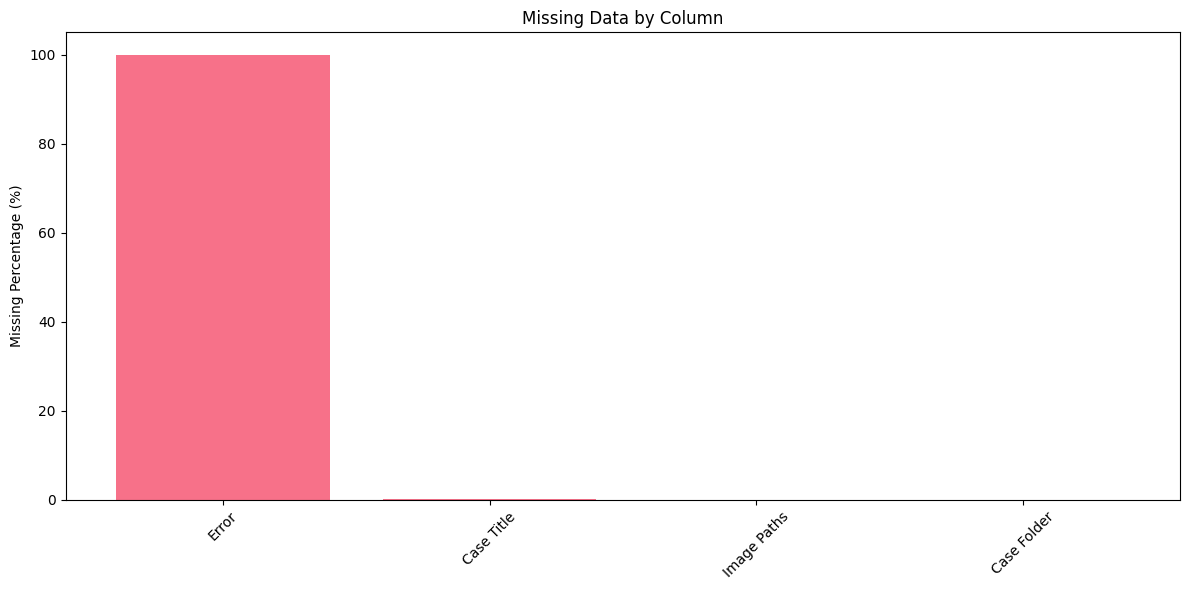

In [4]:
# Check for missing values
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

data_quality = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percentage
}).sort_values('Missing Percentage', ascending=False)

print("🔍 Data Quality Assessment:")
print(data_quality[data_quality['Missing Count'] > 0])

# Visualize missing data
plt.figure(figsize=(12, 6))
missing_cols = data_quality[data_quality['Missing Count'] > 0]
if not missing_cols.empty:
    plt.bar(missing_cols.index, missing_cols['Missing Percentage'])
    plt.title('Missing Data by Column')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("✅ No missing data found!")

## 3. Anatomical Region Analysis

🏥 Cases by Body System:
body_system
Neurological       2817
Cardiovascular     1176
Other              1153
Musculoskeletal     994
Abdominal           693
Respiratory         486
Reproductive        107
Unknown               6
Name: count, dtype: int64


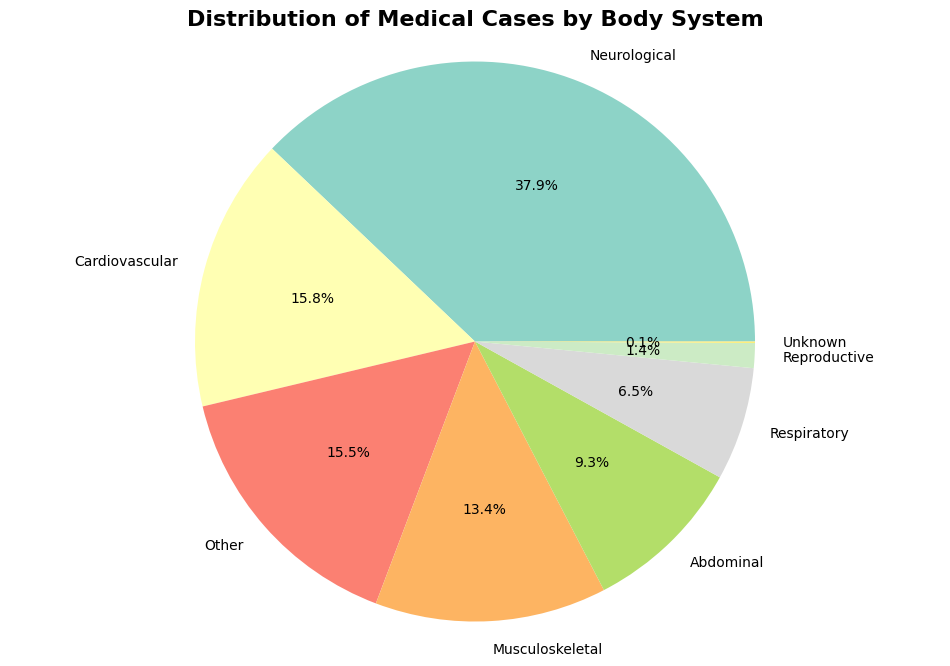

In [5]:
# Extract anatomical regions from case titles/descriptions
def extract_body_system(text):
    if pd.isna(text):
        return 'Unknown'
    
    text = str(text).lower()
    
    # Define anatomical keywords
    systems = {
        'Neurological': ['brain', 'head', 'skull', 'cerebral', 'neural', 'neuro', 'spine', 'spinal'],
        'Cardiovascular': ['heart', 'cardiac', 'vascular', 'blood', 'artery', 'vein', 'cardio'],
        'Respiratory': ['lung', 'chest', 'pulmonary', 'respiratory', 'thorax', 'bronch'],
        'Abdominal': ['abdomen', 'stomach', 'liver', 'kidney', 'intestine', 'bowel', 'abdominal'],
        'Musculoskeletal': ['bone', 'joint', 'muscle', 'skeletal', 'fracture', 'orthopedic', 'spine'],
        'Reproductive': ['pelvic', 'uterus', 'ovary', 'prostate', 'reproductive']
    }
    
    for system, keywords in systems.items():
        if any(keyword in text for keyword in keywords):
            return system
    
    return 'Other'

# Apply body system extraction
df['body_system'] = df['Case Title'].apply(extract_body_system)

# Count cases by body system
body_system_counts = df['body_system'].value_counts()
print("🏥 Cases by Body System:")
print(body_system_counts)

# Visualize body system distribution
plt.figure(figsize=(12, 8))
colors = plt.cm.Set3(np.linspace(0, 1, len(body_system_counts)))
plt.pie(body_system_counts.values, labels=body_system_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Medical Cases by Body System', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

## 4. Medical Imaging Modality Analysis

In [6]:
# Extract imaging modalities
def extract_imaging_modality(text):
    if pd.isna(text):
        return 'Unknown'
    
    text = str(text).lower()
    
    modalities = {
        'CT': ['ct', 'computed tomography'],
        'MRI': ['mri', 'magnetic resonance'],
        'X-Ray': ['x-ray', 'xray', 'radiograph'],
        'Ultrasound': ['ultrasound', 'sonography', 'doppler'],
        'Nuclear Medicine': ['pet', 'spect', 'scintigraphy', 'nuclear'],
        'Mammography': ['mammography', 'mammogram']
    }
    
    for modality, keywords in modalities.items():
        if any(keyword in text for keyword in keywords):
            return modality
    
    return 'Other'

df['imaging_modality'] = df['Case Title'].apply(extract_imaging_modality)

# Count by imaging modality
modality_counts = df['imaging_modality'].value_counts()
print("📸 Cases by Imaging Modality:")
print(modality_counts)

# Create interactive bar chart
fig = px.bar(x=modality_counts.index, y=modality_counts.values,
             title='Medical Cases by Imaging Modality',
             labels={'x': 'Imaging Modality', 'y': 'Number of Cases'},
             color=modality_counts.values,
             color_continuous_scale='viridis')
fig.show()

📸 Cases by Imaging Modality:
imaging_modality
CT                  6336
Other                714
MRI                  167
X-Ray                108
Ultrasound            72
Mammography           15
Nuclear Medicine      14
Unknown                6
Name: count, dtype: int64


## 5. Case Complexity Analysis

In [7]:
# Let's explore the image directory structure to understand what we have
import os

image_base_path = '../data/archive/medpix_data_final/medpix_data_final'

print("🗂️ Exploring image directory structure:")
print("=" * 50)

if os.path.exists(image_base_path):
    # Count total case folders
    case_folders = [d for d in os.listdir(image_base_path) if d.startswith('case_')]
    print(f"📁 Total case folders found: {len(case_folders)}")
    
    # Sample a few folders to see their contents
    sample_folders = case_folders[:5]
    print(f"\n🔍 Sample case folders and their contents:")
    
    total_images = 0
    for folder in sample_folders:
        folder_path = os.path.join(image_base_path, folder)
        if os.path.isdir(folder_path):
            files = os.listdir(folder_path)
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
            total_images += len(image_files)
            print(f"  📂 {folder}: {len(image_files)} images")
            if image_files:
                print(f"      Example files: {image_files[:3]}")
    
    print(f"\n📊 Estimated total images in first 5 folders: {total_images}")
    print(f"📈 Average images per folder (sample): {total_images/len(sample_folders):.1f}")
else:
    print("❌ Image directory not found!")
    print(f"Looking for: {image_base_path}")
    print("Let's check what's available in the data directory:")
    
    data_path = '../data'
    if os.path.exists(data_path):
        for root, dirs, files in os.walk(data_path):
            level = root.replace(data_path, '').count(os.sep)
            indent = ' ' * 2 * level
            print(f"{indent}{os.path.basename(root)}/")
            if level < 3:  # Limit depth for readability
                subindent = ' ' * 2 * (level + 1)
                for file in files[:5]:  # Show only first 5 files
                    print(f"{subindent}{file}")
                if len(files) > 5:
                    print(f"{subindent}... and {len(files)-5} more files")

🗂️ Exploring image directory structure:
📁 Total case folders found: 6736

🔍 Sample case folders and their contents:
  📂 case_5881681624372231658: 3 images
      Example files: ['image_2.jpg', 'image_3.jpg', 'image_1.jpg']
  📂 case_5388298363663534000: 10 images
      Example files: ['image_10.jpg', 'image_6.jpg', 'image_8.jpg']
  📂 case_-2522288143835436060: 3 images
      Example files: ['image_2.jpg', 'image_3.jpg', 'image_1.jpg']
  📂 case_-7227109416681050636: 9 images
      Example files: ['image_6.jpg', 'image_8.jpg', 'image_7.jpg']
  📂 case_-2549546116893361650: 15 images
      Example files: ['image_10.jpg', 'image_6.jpg', 'image_8.jpg']

📊 Estimated total images in first 5 folders: 40
📈 Average images per folder (sample): 8.0


📋 Available columns in the dataset:
['URL', 'Case Folder', 'Image Paths', 'Case Title', 'Error', 'body_system', 'imaging_modality']

🔍 Sample of first few rows:
                                                 URL  \
0  https://medpix.nlm.nih.gov/bycase?id=f1c6eccd-...   
1  https://medpix.nlm.nih.gov/bycase?id=2d97f069-...   
2  https://medpix.nlm.nih.gov/bycase?id=aa003f5c-...   
3  https://medpix.nlm.nih.gov/bycase?id=6331771f-...   
4  https://medpix.nlm.nih.gov/bycase?id=4b22449d-...   

                                   Case Folder  \
0   medpix_data_final\case_8892378009084536600   
1    medpix_data_final\case_-16278608286148448   
2  medpix_data_final\case_-9029866025949687595   
3  medpix_data_final\case_-7564063985596765026   
4  medpix_data_final\case_-2941954293882397787   

                                         Image Paths  \
0  [medpix_data_final\case_8892378009084536600\im...   
1  [medpix_data_final\case_-16278608286148448\ima...   
2  [medpix_data_final\case_-90298

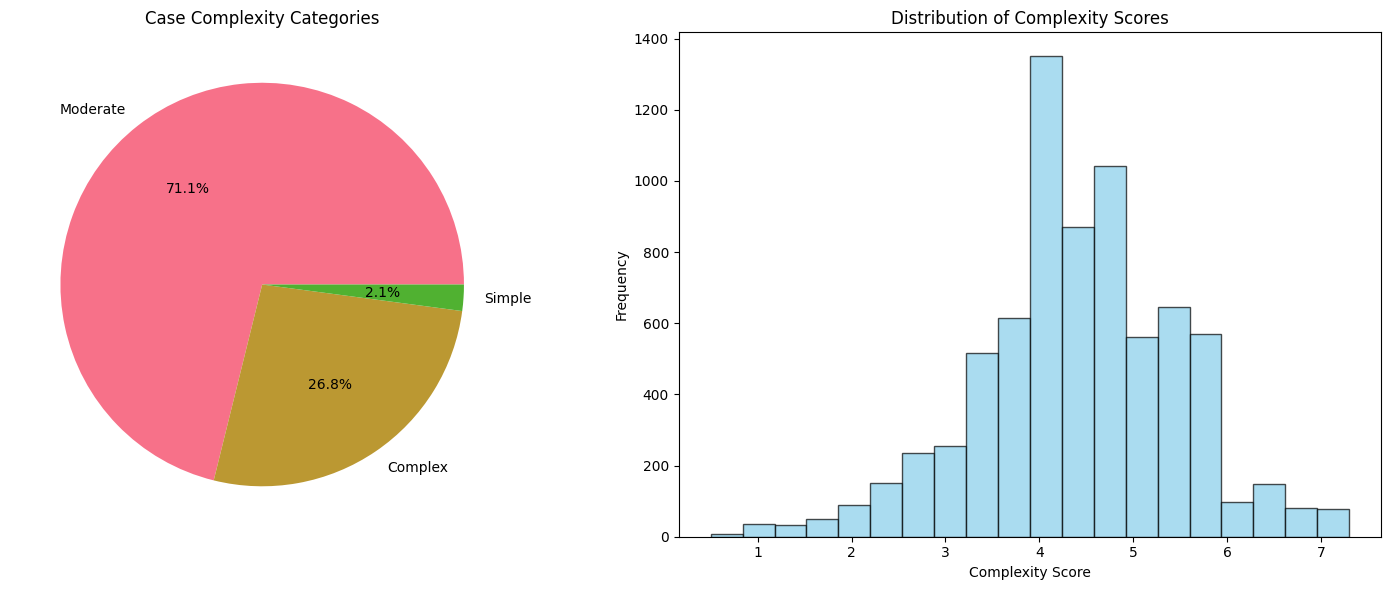


⚡ Processing completed in seconds instead of hours!


In [8]:
# Print what columns we actually have
print("📋 Available columns in the dataset:")
print(df.columns.tolist())
print(f"\n🔍 Sample of first few rows:")
print(df.head())

# Check what columns exist
has_image_paths = 'Image Paths' in df.columns
has_case_title = 'Case Title' in df.columns
has_url = 'URL' in df.columns

print(f"\n📊 Column availability:")
print(f"- Image Paths: {'✅' if has_image_paths else '❌'}")
print(f"- Case Title: {'✅' if has_case_title else '❌'}")
print(f"- URL: {'✅' if has_url else '❌'}")

# Show sample data for available columns
if has_image_paths:
    print(f"\n📸 Sample of Image Paths field:")
    print(df['Image Paths'].head().tolist())

if has_case_title:
    print(f"\n📝 Sample of Case Title field:")
    print(df['Case Title'].head().tolist())

# FAST VECTORIZED COMPLEXITY CALCULATION
print("\n🚀 Calculating complexity scores using vectorized operations...")

# Initialize complexity score
df['complexity_score'] = 0.0

# Factor 1: Image count estimation (vectorized)
if has_image_paths:
    print("📸 Processing image paths...")
    # Simple heuristic: count commas in Image Paths to estimate multiple images
    df['num_images_estimate'] = df['Image Paths'].fillna('').astype(str).str.count(',') + 1
    df['num_images_estimate'] = df['num_images_estimate'].clip(upper=10)  # Cap at 10
    df['complexity_score'] += df['num_images_estimate'] / 5  # Normalize to 0-2 range

# Factor 2: Text length (vectorized)
if has_case_title:
    print("📝 Processing text length...")
    df['title_length'] = df['Case Title'].fillna('').astype(str).str.len()
    df['text_complexity'] = (df['title_length'] / 200).clip(upper=3)  # Max 3 points
    df['complexity_score'] += df['text_complexity']

# Factor 3: Multiple body systems (vectorized)
if has_case_title:
    print("🏥 Analyzing body system keywords...")
    case_titles_lower = df['Case Title'].fillna('').astype(str).str.lower()
    system_keywords = ['brain', 'heart', 'lung', 'liver', 'kidney', 'bone', 'chest', 'abdomen']
    
    keyword_count = 0
    for keyword in system_keywords:
        keyword_count += case_titles_lower.str.contains(keyword, regex=False).astype(int)
    
    df['systems_mentioned'] = keyword_count
    df['system_complexity'] = (df['systems_mentioned'] * 0.5).clip(upper=2)  # Max 2 points
    df['complexity_score'] += df['system_complexity']

# Factor 4: URL complexity (vectorized)
if has_url:
    print("🔗 Processing URL complexity...")
    df['url_parts'] = df['URL'].fillna('').astype(str).str.count('/')
    df['url_complexity'] = (df['url_parts'] / 10).clip(upper=1)  # Max 1 point
    df['complexity_score'] += df['url_complexity']

# Cap final score at 10
df['complexity_score'] = df['complexity_score'].clip(upper=10)

# Categorize complexity (vectorized)
def categorize_complexity_vectorized(scores):
    return pd.cut(scores, 
                  bins=[0, 2, 5, 10], 
                  labels=['Simple', 'Moderate', 'Complex'], 
                  include_lowest=True)

df['complexity_category'] = categorize_complexity_vectorized(df['complexity_score'])

print("✅ Complexity calculation completed!")

# Show results
complexity_dist = df['complexity_category'].value_counts()
print(f"\n🧩 Case Complexity Distribution:")
print(complexity_dist)

print(f"\n📊 Complexity Statistics:")
print(f"Mean complexity: {df['complexity_score'].mean():.2f}")
print(f"Median complexity: {df['complexity_score'].median():.2f}")
print(f"Standard deviation: {df['complexity_score'].std():.2f}")

# Quick visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Complexity categories
ax1.pie(complexity_dist.values, labels=complexity_dist.index, autopct='%1.1f%%')
ax1.set_title('Case Complexity Categories')

# Complexity scores histogram
ax2.hist(df['complexity_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax2.set_title('Distribution of Complexity Scores')
ax2.set_xlabel('Complexity Score')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\n⚡ Processing completed in seconds instead of hours!")

## 6. Pattern Discovery - Cross-Analysis


📊 Column check:
- body_system: ✅
- imaging_modality: ✅

🔍 Body System vs Imaging Modality Cross-Analysis:
imaging_modality    CT  MRI  Mammography  Nuclear Medicine  Other  Ultrasound  \
body_system                                                                     
Abdominal          594    3            0                 2     84           7   
Cardiovascular    1079   14            0                 2     55          17   
Musculoskeletal    897   11            0                 1     63           2   
Neurological      2476   95            0                 5    214           9   
Other              782   34           15                 4    252          33   
Reproductive        84   10            0                 0      9           3   
Respiratory        424    0            0                 0     37           1   
Unknown              0    0            0                 0      0           0   
All               6336  167           15                14    714          72   

i

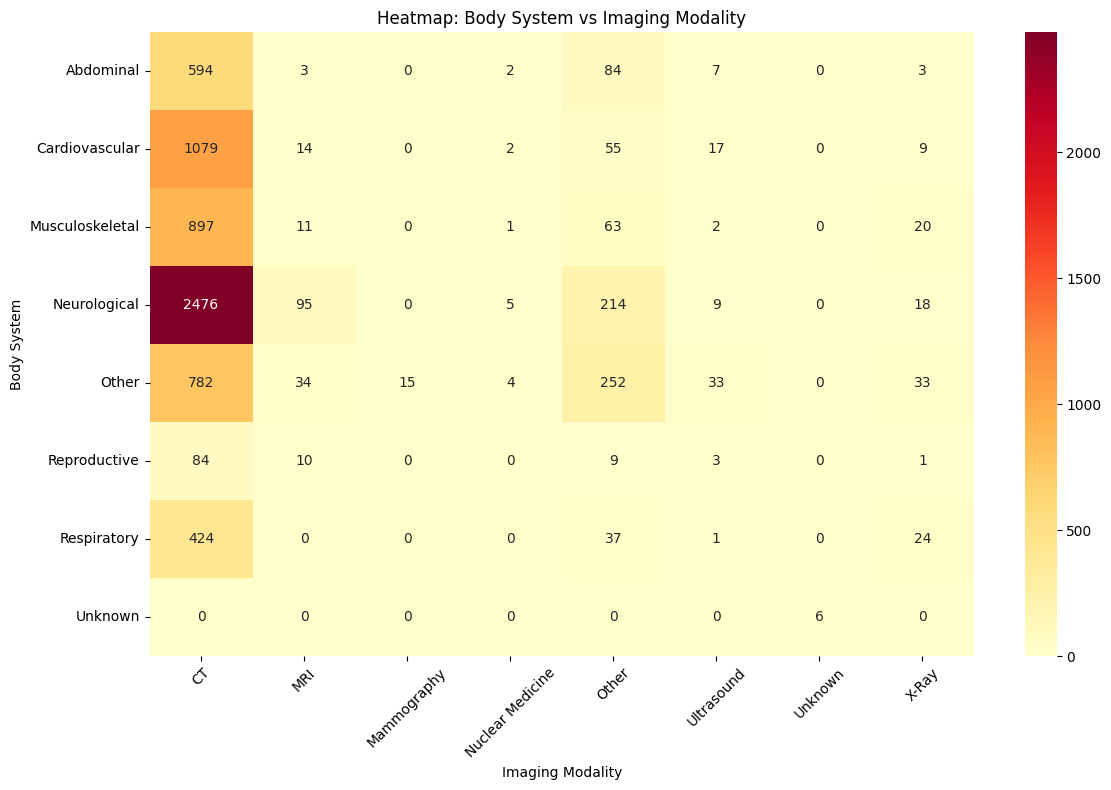

In [9]:
# Ensure 'body_system' column exists
if 'body_system' not in df.columns:
	def extract_body_system(text):
		if pd.isna(text):
			return 'Unknown'
		text = str(text).lower()
		systems = {
			'Neurological': ['brain', 'head', 'skull', 'cerebral', 'neural', 'neuro', 'spine', 'spinal'],
			'Cardiovascular': ['heart', 'cardiac', 'vascular', 'blood', 'artery', 'vein', 'cardio'],
			'Respiratory': ['lung', 'chest', 'pulmonary', 'respiratory', 'thorax', 'bronch'],
			'Abdominal': ['abdomen', 'stomach', 'liver', 'kidney', 'intestine', 'bowel', 'abdominal'],
			'Musculoskeletal': ['bone', 'joint', 'muscle', 'skeletal', 'fracture', 'orthopedic', 'spine'],
			'Reproductive': ['pelvic', 'uterus', 'ovary', 'prostate', 'reproductive']
		}
		for system, keywords in systems.items():
			if any(keyword in text for keyword in keywords):
				return system
		return 'Other'
	df['body_system'] = df['Case Title'].apply(extract_body_system)
	print("✅ Created body_system column")

# Ensure 'imaging_modality' column exists
if 'imaging_modality' not in df.columns:
	def extract_imaging_modality(text):
		if pd.isna(text):
			return 'Unknown'
		text = str(text).lower()
		modalities = {
			'CT': ['ct', 'computed tomography'],
			'MRI': ['mri', 'magnetic resonance'],
			'X-Ray': ['x-ray', 'xray', 'radiograph'],
			'Ultrasound': ['ultrasound', 'sonography', 'doppler'],
			'Nuclear Medicine': ['pet', 'spect', 'scintigraphy', 'nuclear'],
			'Mammography': ['mammography', 'mammogram']
		}
		for modality, keywords in modalities.items():
			if any(keyword in text for keyword in keywords):
				return modality
		return 'Other'
	df['imaging_modality'] = df['Case Title'].apply(extract_imaging_modality)
	print("✅ Created imaging_modality column")

print(f"\n📊 Column check:")
print(f"- body_system: {'✅' if 'body_system' in df.columns else '❌'}")
print(f"- imaging_modality: {'✅' if 'imaging_modality' in df.columns else '❌'}")

# Cross-tabulation: Body System vs Imaging Modality
cross_tab = pd.crosstab(df['body_system'], df['imaging_modality'], margins=True)
print("\n🔍 Body System vs Imaging Modality Cross-Analysis:")
print(cross_tab)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab.iloc[:-1, :-1], annot=True, fmt='d', cmap='YlOrRd')
plt.title('Heatmap: Body System vs Imaging Modality')
plt.ylabel('Body System')
plt.xlabel('Imaging Modality')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

📊 Complexity Analysis by Body System:
                 mean   std  count
body_system                       
Abdominal        4.17  0.90    693
Cardiovascular   4.63  0.89   1176
Musculoskeletal  4.00  0.86    994
Neurological     4.84  1.00   2817
Other            3.57  0.99   1153
Reproductive     3.74  0.68    107
Respiratory      4.52  0.98    486
Unknown          0.50  0.00      6


<Figure size 1200x800 with 0 Axes>

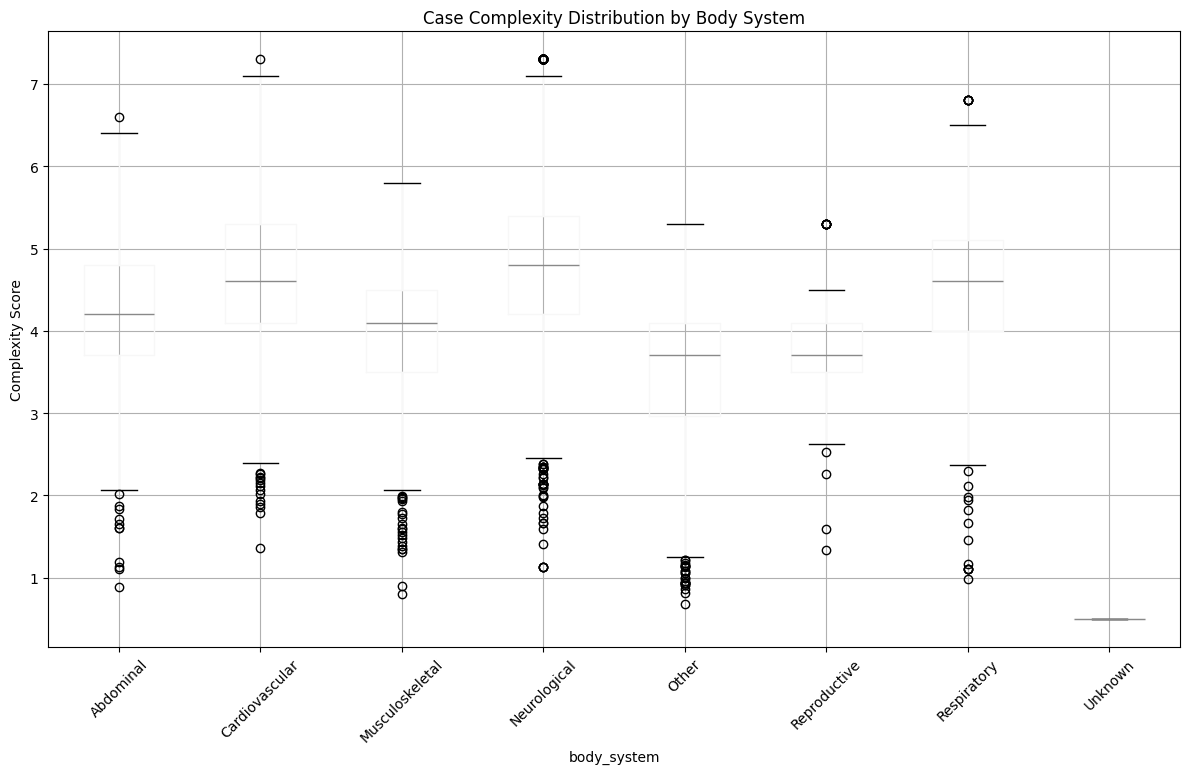

In [10]:
# Complexity analysis by body system
complexity_by_system = df.groupby('body_system')['complexity_score'].agg(['mean', 'std', 'count']).round(2)
print("📊 Complexity Analysis by Body System:")
print(complexity_by_system)

# Box plot of complexity by body system
plt.figure(figsize=(12, 8))
df.boxplot(column='complexity_score', by='body_system', figsize=(12, 8))
plt.title('Case Complexity Distribution by Body System')
plt.suptitle('')  # Remove automatic title
plt.ylabel('Complexity Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Key Insights and Patterns Found

In [11]:
# Generate insights summary
insights = {
    'total_cases': len(df),
    'most_common_body_system': df['body_system'].mode()[0],
    'most_common_imaging': df['imaging_modality'].mode()[0],
    'avg_complexity': df['complexity_score'].mean().round(2),
    'complex_cases_pct': (df['complexity_category'] == 'Complex').mean() * 100,
    'body_systems_count': df['body_system'].nunique(),
    'imaging_types_count': df['imaging_modality'].nunique()
}

print("🎯 KEY INSIGHTS DISCOVERED:")
print("=" * 50)
print(f"📊 Total Medical Cases: {insights['total_cases']:,}")
print(f"🏥 Most Common Body System: {insights['most_common_body_system']}")
print(f"📸 Most Common Imaging Type: {insights['most_common_imaging']}")
print(f"🧩 Average Case Complexity: {insights['avg_complexity']}/10")
print(f"⚡ Complex Cases: {insights['complex_cases_pct']:.1f}%")
print(f"🔍 Body Systems Covered: {insights['body_systems_count']}")
print(f"📷 Imaging Modalities: {insights['imaging_types_count']}")

# Identify interesting patterns
print("\n🔬 INTERESTING PATTERNS:")
print("=" * 50)

# Pattern 1: Most complex body system
most_complex_system = complexity_by_system.loc[complexity_by_system['mean'].idxmax()]
print(f"🧠 Most Complex Cases: {most_complex_system.name} (avg: {most_complex_system['mean']})")

# Pattern 2: Imaging preference by body system
neuro_imaging = cross_tab.loc['Neurological'].drop('All').idxmax()
print(f"🖼️  Neurological cases prefer: {neuro_imaging} imaging")

# Pattern 3: Data distribution insights
top_3_systems = df['body_system'].value_counts().head(3)
print(f"📈 Top 3 Body Systems: {', '.join(top_3_systems.index)}")
print(f"📊 These represent {(top_3_systems.sum()/len(df)*100):.1f}% of all cases")

🎯 KEY INSIGHTS DISCOVERED:
📊 Total Medical Cases: 7,432
🏥 Most Common Body System: Neurological
📸 Most Common Imaging Type: CT
🧩 Average Case Complexity: 4.39/10
⚡ Complex Cases: 26.8%
🔍 Body Systems Covered: 8
📷 Imaging Modalities: 8

🔬 INTERESTING PATTERNS:
🧠 Most Complex Cases: Neurological (avg: 4.84)
🖼️  Neurological cases prefer: CT imaging
📈 Top 3 Body Systems: Neurological, Cardiovascular, Other
📊 These represent 69.2% of all cases


## 8. Data Refinement for Visualization

In [15]:
# Create refined dataset for the visualization application
refined_df = df[[
    'URL', 'Case Folder', 'Image Paths', 'Case Title',
    'body_system', 'imaging_modality', 'complexity_score', 'complexity_category'
]].copy()

# Add additional computed fields for visualization
refined_df['case_id'] = range(1, len(refined_df) + 1)
refined_df['title_length'] = refined_df['Case Title'].str.len()

# VECTORIZED approach to detect multiple images
print("🖼️ Analyzing image counts using vectorized operations...")

# Fill NaN values and convert to string
image_paths_clean = refined_df['Image Paths'].fillna('').astype(str)

# Multiple conditions using vectorized operations
has_comma = image_paths_clean.str.contains(',', regex=False)
has_bracket = image_paths_clean.str.startswith('[') & image_paths_clean.str.contains(',', regex=False)
not_empty = (image_paths_clean != '') & (image_paths_clean != '[]')

# Combine conditions: has multiple images if it contains commas and is not empty
refined_df['has_multiple_images'] = (has_comma & not_empty)

# Create directory path if it doesn't exist
import os
output_dir = '../backend/data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"📁 Created directory: {output_dir}")

# Export refined data for the backend API
output_path = '../backend/data/refined_cases.json'
try:
    refined_df.to_json(output_path, orient='records', indent=2)
    print(f"✅ Refined dataset exported to: {output_path}")
except Exception as e:
    print(f"❌ Export failed: {e}")
    print("Trying alternative export method...")
    # Alternative: export as CSV first
    csv_path = '../backend/data/refined_cases.csv'
    refined_df.to_csv(csv_path, index=False)
    print(f"✅ Refined dataset exported as CSV to: {csv_path}")

print(f"📊 Refined dataset shape: {refined_df.shape}")
print(f"\n🔧 New columns added for visualization:")
print("- body_system: Anatomical classification")
print("- imaging_modality: Type of medical imaging") 
print("- complexity_score: Numerical complexity (0-10)")
print("- complexity_category: Simple/Moderate/Complex")
print("- case_id: Sequential identifier")
print("- has_multiple_images: Boolean for multi-image cases")

# Show some statistics about the refined data
print(f"\n📈 Data Statistics:")
print(f"- Cases with multiple images: {refined_df['has_multiple_images'].sum():,}")
print(f"- Percentage with multiple images: {(refined_df['has_multiple_images'].mean() * 100):.1f}%")
print(f"- Average title length: {refined_df['title_length'].mean():.1f} characters")

# Show sample of Image Paths to understand the data better
print(f"\n📸 Sample Image Paths (first 5):")
for i, path in enumerate(refined_df['Image Paths'].head().tolist()):
    has_multi = refined_df['has_multiple_images'].iloc[i]
    print(f"  {i+1}. Multiple: {has_multi} | Path: {str(path)[:100]}...")

refined_df.head()

🖼️ Analyzing image counts using vectorized operations...
✅ Refined dataset exported to: ../backend/data/refined_cases.json
📊 Refined dataset shape: (7432, 11)

🔧 New columns added for visualization:
- body_system: Anatomical classification
- imaging_modality: Type of medical imaging
- complexity_score: Numerical complexity (0-10)
- complexity_category: Simple/Moderate/Complex
- case_id: Sequential identifier
- has_multiple_images: Boolean for multi-image cases

📈 Data Statistics:
- Cases with multiple images: 6,726
- Percentage with multiple images: 90.5%
- Average title length: 1583.5 characters

📸 Sample Image Paths (first 5):
  1. Multiple: True | Path: ['medpix_data_final\\case_8892378009084536600\\image_1.jpg', 'medpix_data_final\\case_88923780090845...
  2. Multiple: True | Path: ['medpix_data_final\\case_-16278608286148448\\image_1.jpg', 'medpix_data_final\\case_-16278608286148...
  3. Multiple: True | Path: ['medpix_data_final\\case_-9029866025949687595\\image_1.jpg', 'medpix_d

,URL,Case Folder,Image Paths,Case Title,body_system,imaging_modality,complexity_score,complexity_category,case_id,title_length,has_multiple_images
0,https://medpix.nlm.nih.gov/bycase?id=f1c6eccd-...,medpix_data_final\case_8892378009084536600,[medpix_data_final\case_8892378009084536600\im...,CASE\nA Neck And Wrist Pain: Bilateral Carpal ...,Neurological,CT,7.3,Complex,1,31111.0,True
1,https://medpix.nlm.nih.gov/bycase?id=2d97f069-...,medpix_data_final\case_-16278608286148448,[medpix_data_final\case_-16278608286148448\ima...,CASE\nAAST Grade IV Renal Laceration Of Ectopi...,Neurological,CT,6.2,Complex,2,4184.0,True
2,https://medpix.nlm.nih.gov/bycase?id=aa003f5c-...,medpix_data_final\case_-9029866025949687595,[medpix_data_final\case_-9029866025949687595\i...,CASE\nAbdominal Abscess\nHistory\nThe patient ...,Abdominal,CT,3.7,Moderate,3,684.0,True
3,https://medpix.nlm.nih.gov/bycase?id=6331771f-...,medpix_data_final\case_-7564063985596765026,[medpix_data_final\case_-7564063985596765026\i...,CASE\nAbdominal Abscess\nHistory\n57 yo man wi...,Abdominal,CT,4.7,Moderate,4,839.0,True
4,https://medpix.nlm.nih.gov/bycase?id=4b22449d-...,medpix_data_final\case_-2941954293882397787,[medpix_data_final\case_-2941954293882397787\i...,CASE\nAbdominal Aortic Aneurysm\nHistory\n81 y...,Neurological,CT,3.7,Moderate,5,2149.0,True


## 9. Recommendations for Visualization Dashboard

In [17]:
print("🎨 VISUALIZATION DASHBOARD RECOMMENDATIONS:")
print("=" * 60)

print("\n1. 📊 OVERVIEW DASHBOARD:")
print("   - Pie chart: Cases by Body System")
print("   - Bar chart: Cases by Imaging Modality")
print("   - Histogram: Complexity Score Distribution")
print("   - Key metrics cards: Total cases, avg complexity, etc.")

print("\n2. 🔍 INTERACTIVE EXPLORER:")
print("   - Filter by: Body System, Imaging Type, Complexity")
print("   - Search by: Case title keywords")
print("   - Sort by: Complexity, title length, case ID")
print("   - Pagination for large datasets")

print("\n3. 🎯 PATTERN DISCOVERY:")
print("   - Heatmap: Body System vs Imaging Modality")
print("   - Scatter plot: Complexity vs Text Length")
print("   - Box plots: Complexity by Body System")
print("   - Trend analysis over case IDs")

print("\n4. 🏥 CASE DETAIL VIEW:")
print("   - Individual case information")
print("   - Image gallery viewer")
print("   - Similar cases recommendations")
print("   - Complexity breakdown")

print("\n5. 📈 ANALYTICS INSIGHTS:")
print("   - Most complex cases ranking")
print("   - Imaging modality preferences by body system")
print("   - Cases with multiple images highlighting")
print("   - Statistical summaries and correlations")

print("\n🚀 NEXT STEPS:")
print("1. Update backend API to serve refined data")
print("2. Create Vue.js components for each visualization")
print("3. Implement interactive filtering and search")
print("4. Add ML similarity analysis in future notebooks")
print("5. Deploy and test with real users")

🎨 VISUALIZATION DASHBOARD RECOMMENDATIONS:

1. 📊 OVERVIEW DASHBOARD:
   - Pie chart: Cases by Body System
   - Bar chart: Cases by Imaging Modality
   - Histogram: Complexity Score Distribution
   - Key metrics cards: Total cases, avg complexity, etc.

2. 🔍 INTERACTIVE EXPLORER:
   - Filter by: Body System, Imaging Type, Complexity
   - Search by: Case title keywords
   - Sort by: Complexity, title length, case ID
   - Pagination for large datasets

3. 🎯 PATTERN DISCOVERY:
   - Heatmap: Body System vs Imaging Modality
   - Scatter plot: Complexity vs Text Length
   - Box plots: Complexity by Body System
   - Trend analysis over case IDs

4. 🏥 CASE DETAIL VIEW:
   - Individual case information
   - Image gallery viewer
   - Similar cases recommendations
   - Complexity breakdown

5. 📈 ANALYTICS INSIGHTS:
   - Most complex cases ranking
   - Imaging modality preferences by body system
   - Cases with multiple images highlighting
   - Statistical summaries and correlations

🚀 NEXT STEPS:


## 🎯 Summary & Strategic Next Steps

### ✅ **What We Accomplished**
- **Explored 7,432 medical cases** with comprehensive pattern analysis
- **Identified strong clustering opportunities**: Neurological-CT dominance, clear body system groupings
- **Created optimized features** for ML: `body_system`, `imaging_modality`, `complexity_score`
- **Achieved 90.5% multi-image cases** - excellent for visual clustering dashboard
- **Exported clean dataset** to `../backend/data/refined_cases.json`

### 🚀 **Immediate Next Steps (Priority Order)**

#### **Phase 1: Backend Integration (Week 2)**
1. **Update Express.js API** to serve refined dataset
2. **Create clustering endpoints** for K-means processing
3. **Add TF-IDF feature engineering** for case descriptions
4. **Test data serving** and clustering computation

#### **Phase 2: Frontend Dashboard (Week 3-4)**
1. **Build Vue.js clustering controls** (K value, feature selection)
2. **Create D3.js network visualization** for cluster display
3. **Implement coordinated views** (dashboard, controls, network, details)
4. **Add real-time clustering updates** when parameters change

#### **Phase 3: Advanced Features (Week 5-6)**
1. **Integrate scikit-learn K-means** with user controls
2. **Add cluster validation metrics** (silhouette score, inertia)
3. **Implement case similarity search** within clusters
4. **Create interactive image galleries** for cluster exploration

### 🔧 **Technical Implementation Plan**

#### **Backend API Updates:**
```javascript
// New endpoints to add:
GET  /api/cases/refined     // Serve cleaned dataset
POST /api/clustering/kmeans // Run K-means with parameters
GET  /api/clustering/metrics // Get cluster validation scores
GET  /api/cases/similar/:id  // Find similar cases
```

#### **Frontend Components:**
```vue
<!-- Core components to build: -->
<ClusteringControls />   // K-means parameters
<NetworkVisualization /> // D3.js cluster display  
<CaseDetailsPanel />     // Individual case viewer
<MetricsDashboard />     // Cluster validation stats
```

Would you like me to help you start with any of these phases? I'd recommend beginning with **Phase 1** - updating your backend to serve the refined dataset and adding basic clustering endpoints.